# Ví dụ về cách sử dụng phân tích nhân tố để phân tích tương quan và giải quyết vấn đề đa cộng tuyến

In [1]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 808.1 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42564 sha256=6ccb0510c847cffec768c6fd7aaec7a0ec4ae1b8c2799becc9061614c1e68d91
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer


## Tạo dữ liệu mẫu

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from factor_analyzer import FactorAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Thiết lập seed để kết quả có tính nhất quán
np.random.seed(0)

# Tạo dữ liệu có tương quan
n_samples = 1000
square_footage = np.random.normal(loc=2000, scale=500, size=n_samples)  # Diện tích nhà
number_of_bedrooms = square_footage / 1000 + np.random.normal(loc=2, scale=0.5, size=n_samples)  # Số phòng ngủ
number_of_bathrooms = square_footage / 1000 + np.random.normal(loc=1, scale=0.5, size=n_samples)  # Số phòng tắm
yard_size = np.random.normal(loc=500, scale=200, size=n_samples)  # Diện tích sân vườn
garage_size = yard_size / 500 + np.random.normal(loc=2, scale=0.5, size=n_samples)  # Diện tích nhà để xe
total_lot_size = yard_size + np.random.normal(loc=200, scale=50, size=n_samples)  # Tổng diện tích đất

# Tạo DataFrame
data = pd.DataFrame({
    'Square_Footage': square_footage,
    'Number_of_Bedrooms': number_of_bedrooms,
    'Number_of_Bathrooms': number_of_bathrooms,
    'Yard_Size': yard_size,
    'Garage_Size': garage_size,
    'Total_Lot_Size': total_lot_size
})

# Tạo biến phụ thuộc giá nhà
house_price = square_footage * 0.5 + number_of_bedrooms * 10000 + number_of_bathrooms * 5000 + \
              yard_size * 0.3 + garage_size * 2000 + total_lot_size * 0.2 + np.random.normal(loc=0, scale=10000, size=n_samples)
data['House_Price'] = house_price

print(data.head())

   Square_Footage  Number_of_Bedrooms  Number_of_Bathrooms   Yard_Size  \
0     2882.026173            5.160008             3.115566  818.654723   
1     2200.078604            4.646316             2.344094  613.744480   
2     2489.368992            4.278212             3.512437  477.102591   
3     3120.446600            5.172804             3.641259  550.326050   
4     2933.778995            5.047806             3.893373  257.828872   

   Garage_Size  Total_Lot_Size   House_Price  
0     3.943984     1034.140914  97384.671444  
1     4.149339      776.871670  58727.226124  
2     3.089751      600.256597  69178.366638  
3     3.668876      722.213308  77767.611506  
4     1.646492      377.853316  88512.984211  


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Square_Footage       1000 non-null   float64
 1   Number_of_Bedrooms   1000 non-null   float64
 2   Number_of_Bathrooms  1000 non-null   float64
 3   Yard_Size            1000 non-null   float64
 4   Garage_Size          1000 non-null   float64
 5   Total_Lot_Size       1000 non-null   float64
 6   House_Price          1000 non-null   float64
dtypes: float64(7)
memory usage: 54.8 KB


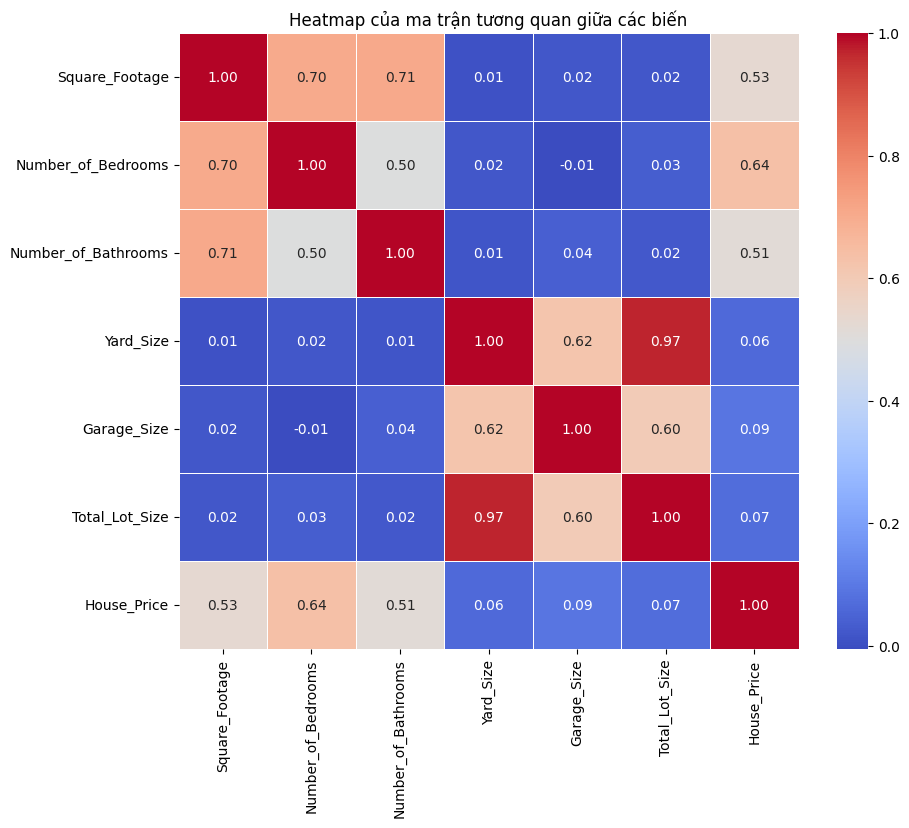

In [5]:
# Tính ma trận tương quan
correlation_matrix = data.corr()

# Vẽ heatmap của ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap của ma trận tương quan giữa các biến')
plt.show()

Có thể thấy một số điểm quan trọng về mối tương quan giữa các biến:
- Mối quan hệ mạnh giữa các biến liên quan đến kích thước của ngôi nhà: Square_Footage và Number_of_Bedrooms, Square_Footage và Number_of_Bathrooms.
- Mối quan hệ mạnh giữa các biến liên quan đến đất: Yard_Size và Garage_Size, Yard_Size và Total_Lot_Size, Garage_Size và Total_Lot_Size.
- Tương quan giữa giá nhà và các yếu tố khác: House_Price và Square_Footage, House_Price và Number_of_Bedrooms.

Hành động tiếp theo:
- Sử dụng Phân tích Nhân tố: Để hiểu rõ hơn về cấu trúc tương quan này, chúng ta tiến hành phân tích nhân tố và những tương quan mạnh này cho thấy rằng sử dụng phân tích nhân tố có thể giúp giảm đa cộng tuyến bằng cách tạo ra các nhân tố độc lập thay vì sử dụng trực tiếp các biến có tương quan cao này.

## Phân tích nhân tố

Tiếp theo, chúng ta sẽ thực hiện phân tích nhân tố để tìm ra các nhân tố chính.

In [7]:
# Kiểm tra độ thích hợp của phân tích nhân tố
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Thực hiện Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(data)

print("Bartlett's Test of Sphericity:")
print(f"Chi-square Value: {chi_square_value}")
print(f"P-value: {p_value}")

# Kiểm định KMO
kmo_all, kmo_model=calculate_kmo(data)
print("KMO model:", kmo_model)

Bartlett's Test of Sphericity:
Chi-square Value: 5384.184669730112
P-value: 0.0
KMO model: 0.676357167276583


Với KMO Model đạt được là 0.68, điều này cho thấy dữ liệu của có mức độ phù hợp tương đối để thực hiện phân tích nhân tố.

In [8]:
# Khởi tạo Phân tích Nhân Tố
fa = FactorAnalyzer(10, rotation=None)
fa.fit(data.drop('House_Price', axis=1))

# Cài đặt của Phân tích Nhân Tố
FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='principal', n_factors=3, rotation=None, rotation_kwargs={},
               use_smc=True)

# Lấy Giá Trị Riêng
ev = fa.get_eigenvalues()
print("Eigenvalues:", ev)

Eigenvalues: (array([2.49139785, 2.26020008, 0.5313083 , 0.46926539, 0.22069401,
       0.02713438]), array([ 2.34774797e+00,  1.99538334e+00,  1.18167641e-01,  2.62550710e-02,
        1.09331631e-03, -6.51878737e-07]))


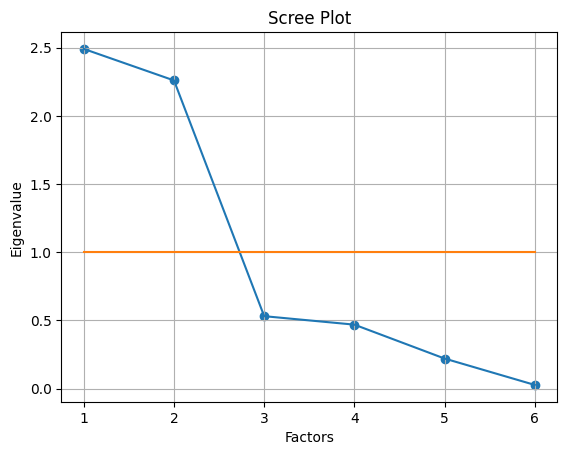

In [9]:
plt.scatter(range(1,data.drop('House_Price', axis=1).shape[1]+1),ev[0])
plt.plot(range(1,data.drop('House_Price', axis=1).shape[1]+1),ev[0])
plt.plot(range(1,data.drop('House_Price', axis=1).shape[1]+1),np.zeros(shape=(data.drop('House_Price', axis=1).shape[1],)) + 1)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [10]:
# Thực hiện phân tích nhân tố
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='principal')
fa.fit(data.drop('House_Price', axis=1))

# Lấy ma trận tải trọng
loadings = fa.loadings_

# Tạo DataFrame cho ma trận tải trọng
loading_df = pd.DataFrame(loadings, columns=['Factor1', 'Factor2'], index=data.drop('House_Price', axis=1).columns)
print("Ma trận tải trọng:")
print(loading_df)

Ma trận tải trọng:
                      Factor1   Factor2
Square_Footage       0.202717  0.906539
Number_of_Bedrooms   0.185436  0.818596
Number_of_Bathrooms  0.195091  0.818061
Yard_Size            0.943461 -0.201036
Garage_Size          0.778413 -0.157917
Total_Lot_Size       0.938851 -0.184614


**Factor1 có hệ số tải nhân tố cao từ:**
- Yard_Size (0.943461)
- Garage_Size (0.778413)
- Total_Lot_Size (0.938851)

Các biến này chủ yếu liên quan đến diện tích đất và các khu vực phụ, vì vậy chúng ta có thể đặt tên cho Factor1 là Land_Aux_Areas_Factor.

**Factor2 có tải trọng cao từ:**

- Square_Footage (0.906539)
- Number_of_Bedrooms (0.818596)
- Number_of_Bathrooms (0.818061)

Các biến này chủ yếu liên quan đến kích thước ngôi nhà và các phòng, vì vậy chúng ta có thể đặt tên cho Factor2 là House_Size_Factor.

In [11]:
# Trích xuất nhân tố
factor_scores = fa.transform(data.drop('House_Price', axis=1))
factor_df = pd.DataFrame(factor_scores, columns=['Land_Aux_Areas_Factor', 'House_Size_Factor'])
print(factor_df)

     Land_Aux_Areas_Factor  House_Size_Factor
0                 1.961487           1.065385
1                 0.964345          -0.005550
2                 0.013237           0.909982
3                 0.865975           1.821774
4                -1.305182           2.231472
..                     ...                ...
995              -0.385602           1.161613
996               1.875739          -0.435208
997               0.190172           0.094203
998               1.228344          -2.014889
999              -0.747734          -0.512898

[1000 rows x 2 columns]


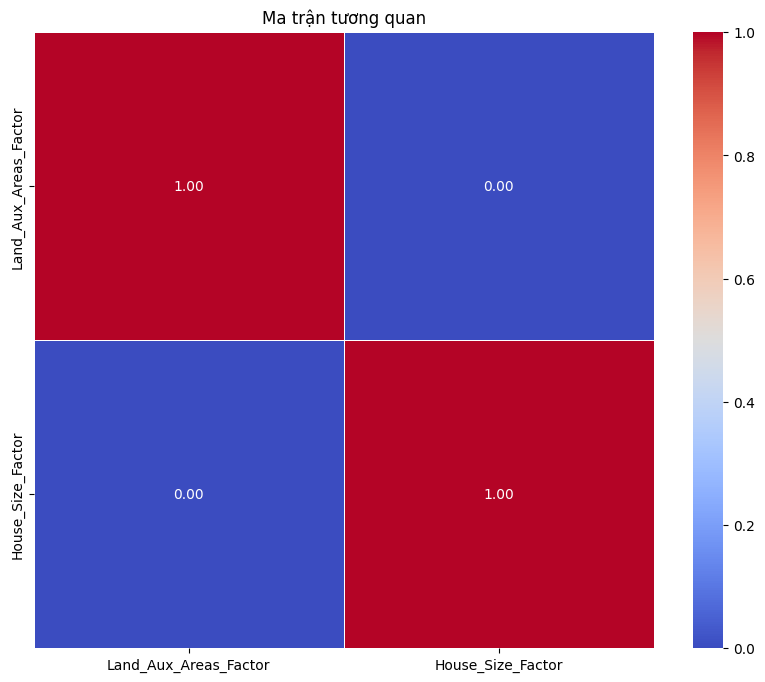

In [12]:
# Vẽ biểu đồ ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(factor_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Ma trận tương quan')
plt.show()

Ta có thể thấy rằng vấn đề đa cộng tuyến trong dữ liệu đã được giải quyết. Tiếp theo ta có thể sử dụng các nhân tố này để xây dựng các mô hình như mô hình hồi quy và đánh giá hiệu quả của mô hình thông qua các chỉ số như R-squared, AIC, BIC và các thống kê khác.